# Calculating the root mean square fluctuation over a trajectory

We calculate the RMSF of the alpha-carbons in adenylate kinase (AdK) as it transitions from an open to closed structure, with reference to the average conformation of AdK.

**Last updated:** December 2022 with MDAnalysis 2.4.0-dev0

**Minimum version of MDAnalysis:** 1.0.0

**Packages required:**
    
* MDAnalysis (<a data-cite="michaud-agrawal_mdanalysis_2011" href="https://doi.org/10.1002/jcc.21787">Michaud-Agrawal *et al.*, 2011</a>, <a data-cite="gowers_mdanalysis_2016" href="https://doi.org/10.25080/Majora-629e541a-00e">Gowers *et al.*, 2016</a>)
* [MDAnalysisData](https://www.mdanalysis.org/MDAnalysisData/)
* [matplotlib](https://matplotlib.org/)

**Optional packages for visualisation:**
* [nglview](http://nglviewer.org/nglview/latest/)

Throughout this tutorial we will include cells for visualising Universes with the [NGLView](http://nglviewer.org/nglview/latest/api.html) library. However, these will be commented out, and we will show the expected images generated instead of the interactive widgets.

**See also**

* [RMSD](rmsd.ipynb)
* [Pairwise (2D) RMSD](pairwise_rmsd.ipynb)

<div class="alert alert-info">
    
**Note**

MDAnalysis implements RMSD calculation using the fast QCP algorithm (<a data-cite="theobald_rapid_2005" href="https://doi.org/10.1107/S0108767305015266">Theobald, 2005</a>) and a rotation matrix *R* that minimises the RMSD (<a data-cite="liu_fast_2009" href="https://doi.org/10.1002/jcc.21439">Liu *et al.*, 2009</a>). Please cite (<a data-cite="theobald_rapid_2005" href="https://doi.org/10.1107/S0108767305015266">Theobald, 2005</a>) and (<a data-cite="liu_fast_2009" href="https://doi.org/10.1002/jcc.21439">Liu *et al.*, 2009</a>) when using the ``MDAnalysis.analysis.align`` and ``MDAnalysis.analysis.rms`` modules in published work.

</div>

In [1]:
import MDAnalysis as mda
from MDAnalysisData import datasets
from MDAnalysis.analysis import rms, align
import nglview as nv

import warnings
# suppress some MDAnalysis warnings about writing PDB files
warnings.filterwarnings('ignore')

## Loading files

The test files we will be working with here are an equilibrium trajectory of adenylate kinase (AdK), a phosophotransferase enzyme. (<a data-cite="seyler_molecular_2017" href="https://doi.org/10.6084/m9.figshare.5108170.v1">Seyler and Beckstein, 2017</a>) AdK has three domains: 

  * CORE
  * LID: an ATP-binding domain
  * NMP: an AMP-binding domain
  
The LID and NMP domains move around the stable CORE as the enzyme transitions between the opened and closed conformations. We therefore might wonder whether the LID and NMP residues are more mobile than the CORE residues. One way to quantify this flexibility is by calculating the root mean square fluctuation (RMSF) of atomic positions.

Note: downloading these datasets from MDAnalysisData may take some time.

In [2]:
adk = datasets.fetch_adk_equilibrium()

In [3]:
u = mda.Universe(adk.topology, adk.trajectory)

## Background

The root-mean-square-fluctuation (RMSF) of a structure is the time average of the [RMSD](rmsd.ipynb). It is calculated according to the below equation, where $\mathbf{x}_i$ is the coordinates of particle $i$, and $\langle\mathbf{x}_i\rangle$ is the ensemble average position of $i$.

$$\rho_i = \sqrt{\left\langle (\mathbf{x}_i - \langle\mathbf{x}_i\rangle)^2 \right\rangle}$$

Where the RMSD quantifies how much a structure diverges from a reference over time, the RSMF can reveal which areas of the system are the most mobile. While RMSD is frequently calculated to an initial state, the RMSF should be calculated to an average structure of the simulation. An area of the structure with high RMSF values frequently diverges from the average, indicating high mobility. When RMSF analysis is carried out on proteins, it is typically restricted to backbone or alpha-carbon atoms; these are more characteristic of conformational changes than the more flexible side-chains. 

## Creating an average structure

We can generate an average structure to align to with the ``align.AverageStructure`` class. Here we first align to the first frame (`ref_frame=0`), and then average the coordinates.

In [4]:
average = align.AverageStructure(u, u, select='protein and name CA',
                                 ref_frame=0).run()
ref = average.results.universe

## Aligning the trajectory to a reference

``rms.RMSF`` does not allow on-the-fly alignment to a reference, and presumes that you have already aligned the trajectory. Therefore we need to first align our trajectory to the average conformation.

In [5]:
aligner = align.AlignTraj(u, ref,
                          select='protein and name CA',
                          in_memory=True).run()

You may not have enough memory to load the trajectory into memory. In that case, save this aligned trajectory to a file and re-load it into MDAnalysis by uncommenting the code below.

In [6]:
# aligner = align.AlignTraj(u, ref,
#                           select='protein and name CA',
#                           filename='aligned_traj.dcd',
#                           in_memory=False).run()
# u = mda.Universe(PSF, 'aligned_traj.dcd')

## Calculating RMSF

The trajectory is now fitted to the reference, and the RMSF ([API docs](https://docs.mdanalysis.org/stable/documentation_pages/analysis/rms.html#MDAnalysis.analysis.rms.RMSF)) can be calculated.

<div class="alert alert-info">
    
**Note**

MDAnalysis implements an algorithm that computes sums of squares and avoids underflows or overflows. Please cite (<a data-cite="welford_note_1962" href="https://doi.org/10.1080/00401706.1962.10490022">Welford, 1962</a>) when using the ``MDAnalysis.analysis.rms.RMSF`` class in published work.

</div>



In [7]:
c_alphas = u.select_atoms('protein and name CA')
R = rms.RMSF(c_alphas).run()

## Plotting RMSF

We can now plot the RMSF using the common plotting package [matplotlib](https://matplotlib.org/3.1.1/gallery/index.html).

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

As we can see, the LID and NMP residues indeed move much more compared to the rest of the enzyme.

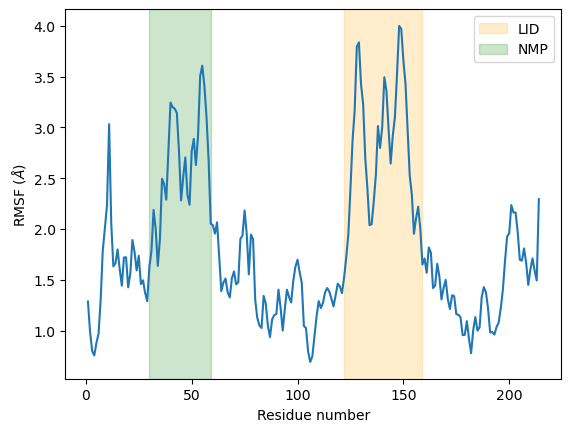

In [9]:
plt.plot(c_alphas.resids, R.results.rmsf)
plt.xlabel('Residue number')
plt.ylabel('RMSF ($\AA$)')
plt.axvspan(122, 159, zorder=0, alpha=0.2, color='orange', label='LID')
plt.axvspan(30, 59, zorder=0, alpha=0.2, color='green', label='NMP')
plt.legend()

## Visualising RMSF as B-factors

Colouring a protein by RMSF allows you to visually identify regions of high fluctuation. This is commonly done by setting temperature factor (also known as b-factor) values, writing out to a format with B-factor specification (e.g. PDB), and visualising the file in a program such as [VMD](https://www.ks.uiuc.edu/Research/vmd/) or nglview.

MDAnalysis uses the `tempfactor` topology attribute for this information. Below, we iterate through each residue of the protein and set the `tempfactor` attribute for *every* atom in the residue to the alpha-carbon RMSF value; this is necessary so every atom in the residue is coloured with the alpha-carbon RMSF.

In [10]:
u.add_TopologyAttr('tempfactors') # add empty attribute for all atoms
protein = u.select_atoms('protein') # select protein atoms
for residue, r_value in zip(protein.residues, R.results.rmsf):
    residue.atoms.tempfactors = r_value

Below we visualise these values with a rainbow colour scheme. Purple values correspond to low RMSF values, whereas red values correspond to high RMSFs.

In [11]:
# view = nv.show_mdanalysis(u)
# view.update_representation(color_scheme='bfactor')
# view

In [12]:
# from nglview.contrib.movie import MovieMaker
# movie = MovieMaker(
#     view,
#     step=100,  # keep every 100th frame
#     output='images/rmsf-view.gif',
#     render_params={"factor": 3},  # set to 4 for highest quality
# )
# movie.make()

<center>
<div style='width: 800px'>
    
![rmsf-bfactor-view](images/rmsf-view.gif)
    
</div>
</center>

You can also write the atoms to a file and visualise it in another program. As the original Universe did not contain `altLocs`, `icodes` or `occupancies` for each atom, some warnings will be printed (which are not visible here).

In [13]:
u.atoms.write('rmsf_tempfactors.pdb')

## References

[1] Richard&nbsp;J. Gowers, Max Linke, Jonathan Barnoud, Tyler J.&nbsp;E. Reddy, Manuel&nbsp;N. Melo, Sean&nbsp;L. Seyler, Jan Domański, David&nbsp;L. Dotson, Sébastien Buchoux, Ian&nbsp;M. Kenney, and Oliver Beckstein.
<span class="bibtex-protected">MDAnalysis</span>: <span class="bibtex-protected">A</span> <span class="bibtex-protected">Python</span> <span class="bibtex-protected">Package</span> for the <span class="bibtex-protected">Rapid</span> <span class="bibtex-protected">Analysis</span> of <span class="bibtex-protected">Molecular</span> <span class="bibtex-protected">Dynamics</span> <span class="bibtex-protected">Simulations</span>.
<em>Proceedings of the 15th Python in Science Conference</em>, pages 98–105, 2016.
00152.
URL: <a href="https://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html">https://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html</a>, <a href="https://doi.org/10.25080/Majora-629e541a-00e">doi:10.25080/Majora-629e541a-00e</a>.

[2] Pu&nbsp;Liu, Dimitris&nbsp;K. Agrafiotis, and Douglas&nbsp;L. Theobald.
Fast determination of the optimal rotational matrix for macromolecular superpositions.
<em>Journal of Computational Chemistry</em>, pages n/a–n/a, 2009.
URL: <a href="http://doi.wiley.com/10.1002/jcc.21439">http://doi.wiley.com/10.1002/jcc.21439</a>, <a href="https://doi.org/10.1002/jcc.21439">doi:10.1002/jcc.21439</a>.

[3] Naveen Michaud-Agrawal, Elizabeth&nbsp;J. Denning, Thomas&nbsp;B. Woolf, and Oliver Beckstein.
<span class="bibtex-protected">MDAnalysis</span>: <span class="bibtex-protected">A</span> toolkit for the analysis of molecular dynamics simulations.
<em>Journal of Computational Chemistry</em>, 32(10):2319–2327, July 2011.
00778.
URL: <a href="http://doi.wiley.com/10.1002/jcc.21787">http://doi.wiley.com/10.1002/jcc.21787</a>, <a href="https://doi.org/10.1002/jcc.21787">doi:10.1002/jcc.21787</a>.

[4] Sean Seyler and Oliver Beckstein.
Molecular dynamics trajectory for benchmarking <span class="bibtex-protected">MDAnalysis</span>.
June 2017.
00002.
URL: <a href="https://figshare.com/articles/Molecular_dynamics_trajectory_for_benchmarking_MDAnalysis/5108170">https://figshare.com/articles/Molecular_dynamics_trajectory_for_benchmarking_MDAnalysis/5108170</a>, <a href="https://doi.org/10.6084/m9.figshare.5108170.v1">doi:10.6084/m9.figshare.5108170.v1</a>.

[5] Douglas&nbsp;L. Theobald.
Rapid calculation of <span class="bibtex-protected">RMSDs</span> using a quaternion-based characteristic polynomial.
<em>Acta Crystallographica Section A Foundations of Crystallography</em>, 61(4):478–480, July 2005.
00127.
URL: <a href="http://scripts.iucr.org/cgi-bin/paper?S0108767305015266">http://scripts.iucr.org/cgi-bin/paper?S0108767305015266</a>, <a href="https://doi.org/10.1107/S0108767305015266">doi:10.1107/S0108767305015266</a>.

[6] B.&nbsp;P. Welford.
Note on a <span class="bibtex-protected">Method</span> for <span class="bibtex-protected">Calculating</span> <span class="bibtex-protected">Corrected</span> <span class="bibtex-protected">Sums</span> of <span class="bibtex-protected">Squares</span> and <span class="bibtex-protected">Products</span>.
<em>Technometrics</em>, 4(3):419–420, August 1962.
URL: <a href="https://amstat.tandfonline.com/doi/abs/10.1080/00401706.1962.10490022">https://amstat.tandfonline.com/doi/abs/10.1080/00401706.1962.10490022</a>, <a href="https://doi.org/10.1080/00401706.1962.10490022">doi:10.1080/00401706.1962.10490022</a>.